# Pretraitement
Les fichiers qui utilisent l'extension `.json` sont en fait une liste de dictionnaire python. Il est donc impossible de l'importer avec la librairie `json` puisque les dictionnaires python utilisent des `single quotes` et non des `double quotes` pout les clefs.  

Les fichiers doivent être convertis en csv.  

In [ ]:
# Chaque ligne du fichier est un objet JSON sérialisé (un dict Python)

json_seq = {
    'user_id': '76561198215949741', 
    'items_count': 2, 
    'steam_id': '76561198215949741', 
    'user_url': 'http://steamcommunity.com/profiles/76561198215949741', 
    'items': [
        {
            'item_id': '730', 
            'item_name': 'Counter-Strike: Global Offensive', 
            'playtime_forever': 38830, 
            'playtime_2weeks': 1025
        }, 
        {
            'item_id': '236110', 
            'item_name': 'Dungeon Defenders II', 
            'playtime_forever': 23, 
            'playtime_2weeks': 23
        }
    ]
}

In [1]:
import pandas as pd
import numpy as np
import math

In [1]:
# Fonction pour importer les dictionnaires Python en liste

import ast

def import_python_dicts(filename, lines=None):
    dicts = []
    line_count = 0
    with open(filename, 'r') as file:
        for line in file:
            try:
                dictionary = ast.literal_eval(line.strip())
                dicts.append(dictionary)
            except (SyntaxError, ValueError) as e:
                print(f"Error parsing line: {line.strip()} - {e}")
            line_count += 1
            if lines == line_count:
                break
    return dicts

In [ ]:
items = import_python_dicts('./data/australian_users_items.json')
print('loaded', len(items), 'items')

## Games
game_id, name, temps_total_joué, nombre_joueurs_joué

In [32]:
games = {}
time_played = {}
player_count = {}
all_times_played = {}

for user in items:
    for item in user['items']:
        games[item['item_id']] = item['item_name']
        if item['item_id'] not in time_played:
            time_played[item['item_id']] = item['playtime_forever']
        else:
            time_played[item['item_id']] += item['playtime_forever']
        
        if item['playtime_forever'] > 0:
            if item['item_id'] not in player_count:
                player_count[item['item_id']] = 1
            else:
                player_count[item['item_id']] += 1

            if item['item_id'] not in all_times_played:
                all_times_played[item['item_id']] = [item['playtime_forever']]
            else:
                all_times_played[item['item_id']].append(item['playtime_forever'])

In [ ]:
games_df = pd.DataFrame(list(games.items()), columns=['game_id', 'name'])

for i, row in games_df.iterrows():
    games_df.at[i, 'time_played'] = math.ceil(time_played[row['game_id']] / 60) if row['game_id'] in time_played else 0
    games_df.at[i, 'player_count'] = player_count[row['game_id']] if row['game_id'] in player_count else 0
    games_df.at[i, 'median_time_played'] = math.ceil(sorted(all_times_played[row['game_id']])[len(all_times_played[row['game_id']]) // 2] / 60) if row['game_id'] in all_times_played else 0

games_df['time_played'] = games_df['time_played'].astype(int)
games_df['player_count'] = games_df['player_count'].astype(int)
games_df['median_time_played'] = games_df['median_time_played'].astype(int)
games_df.to_csv('./data_csv/games_data.csv', index=False)

In [48]:
# show max median time played with player count over 100
df_over_100 = games_df[games_df['player_count'] > 10]
max_median_time_played = df_over_100['median_time_played'].max()
print(df_over_100[df_over_100['median_time_played'] == max_median_time_played])


    game_id                              name  time_played  player_count  \
178     730  Counter-Strike: Global Offensive     13086405         43279   

     median_time_played  
178                 113  


## User lib
user_id, game_id, playtime (hours), active (bool)

In [15]:
users_games = []
for user in items:
    if user['items_count'] == 0:
        continue
    for item in user['items']:
        # if item['playtime_forever'] > 0:
        users_games.append({
            'user_id': user['user_id'],
            'game_id': item['item_id'],
            'playtime': math.ceil(item['playtime_forever'] / 60),
            'active': item['playtime_2weeks'] > 0
        })

In [16]:
users_games_df = pd.DataFrame(users_games)
users_games_df.to_csv('./data_csv/users_games.csv', index=False)

## User data
user_id, games_count, total_playtime, most_played_game_id

In [49]:
users_data = []
for user in items:
    if user['items_count'] == 0:
        continue

    total_playtime = 0
    for item in user['items']:
        total_playtime += item['playtime_forever']

    played_games = len([item for item in user['items'] if item['playtime_forever'] > 0])
    
    # if total_playtime == 0:
    #     continue

    most_played_game = max(user['items'], key=lambda x: x['playtime_forever'])

    users_data.append({
        'user_id': user['user_id'],
        'items_count': user['items_count'],
        'played_games': played_games,
        'total_playtime': math.ceil(total_playtime / 60),
        'most_played_game_id': most_played_game['item_id'],
    })

In [50]:
users_data_df = pd.DataFrame(users_data)
users_data_df.to_csv('./data_csv/users_data.csv', index=False)

## Calculer des bins

In [2]:
user_games_df = pd.read_csv('./data_csv/users_games.csv')
games_df = pd.read_csv('./data_csv/games_data.csv')

In [3]:
games_bins = {}

for _, game in games_df.iterrows():
    game_id = game['game_id']
    playtime = user_games_df[user_games_df['game_id'] == game_id]['playtime']
    bin_edges = np.percentile(playtime, np.linspace(0, 100, 6)).astype(int).tolist()[1:]
    games_bins[game_id] = bin_edges

col_names = ['max_bin_1', 'max_bin_2', 'max_bin_3', 'max_bin_4', 'max_bin_5']
# add to games_df
for i, row in games_df.iterrows():
    game_id = row['game_id']
    bins = games_bins[game_id]
    for j, bin_edge in enumerate(bins):
        games_df.at[i, col_names[j]] = bin_edge

for col in col_names:
    games_df[col] = games_df[col].astype(int)

games_df.to_csv('./data_csv/games_data_bins.csv', index=False)

[0, 4, 20, 50, 120, 7091]


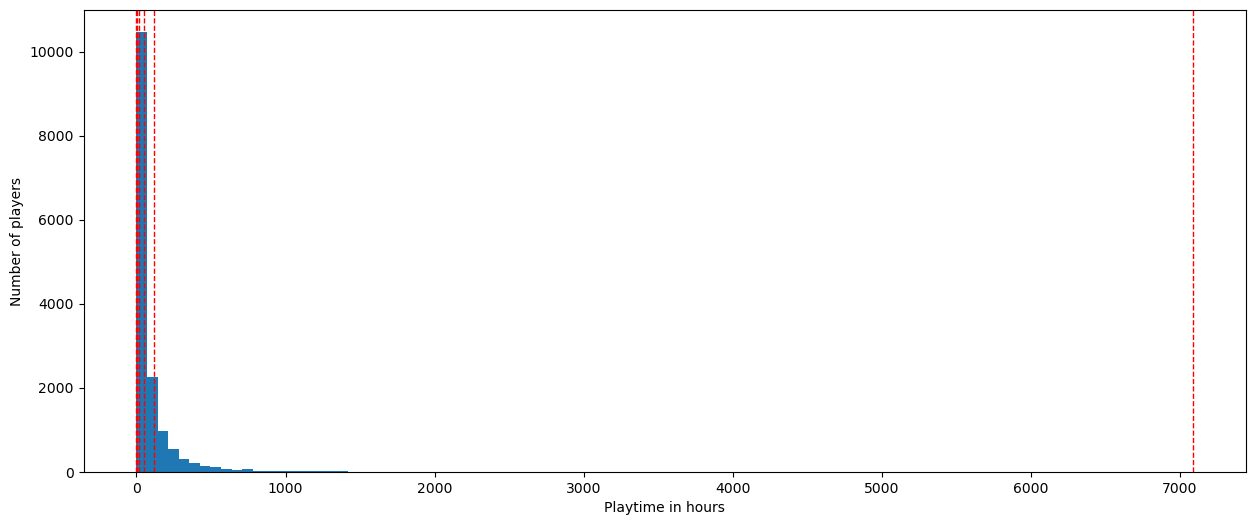

In [ ]:
import matplotlib.pyplot as plt

# cs_go = user_games_df[user_games_df['game_id'] == 730]
users_playtime = user_games_df[user_games_df['game_id'] == 8930]

playtime = users_playtime['playtime']
num_bins = 5

# pour avoir des bins de même taille (meme nombre de joueurs dans chaque bin)
bin_edges = np.percentile(playtime, np.linspace(0, 100, num_bins + 1)).astype(int).tolist()
print(bin_edges)

plt.figure(figsize=(15, 6))
plt.hist(users_playtime['playtime'], bins=100)
plt.xlabel('Playtime in hours')
plt.ylabel('Number of players')
for edge in bin_edges:
    plt.axvline(edge, color='r', linestyle='dashed', linewidth=1)
plt.show()